In [11]:
# Question:
# What is the shortest distance to fly between all fifty States?

# I'll be using the dataset: 
# https://www.kaggle.com/datasets/flashgordon/usa-airport-dataset

# Here is some info about the attributes present in the dataset:

# Origin_airport: Three letter airport code of the origin airport
# Destination_airport: Three letter airport code of the destination airport
# Origin_city: Origin city name
# Destination_city: Destination city name
# Passengers: Number of passengers transported from origin to destination
# Seats: Number of seats available on flights from origin to destination
# Flights: Number of flights between origin and destination (multiple records for one month, many with flights > 1)
# Distance: Distance (to nearest mile) flown between origin and destination
# Fly_date: The date (yyyymm) of flight
# Origin_population: Origin city's population as reported by US Census
# Destination_population: Destination city's population as reported by US Census

In [12]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import plotly.express as px
import networkx as nx


In [13]:
def GetCoords(city):
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(city  + ", US")
    return location.latitude, location.longitude


In [14]:
# Let's get the 
def GenerateData():
        
    dfFlights = pd.read_csv("G:\\My Drive\\Data\\DataStumbler\\Datasets\\Airports2.csv")

    # Just to make it easier let's just keep what we need

    dfFlights = dfFlights[['Origin_city','Destination_city','Distance']].copy()

    # Drop duplicates

    dfFlights = dfFlights.drop_duplicates()

    # Now we'll change the city to just have the State instead.

    dfFlights["Origin_state"]=''
    dfFlights["Destination_state"]=''

    stateLookup = [ ['Alabama','AL'], ['Alaska','AK'], ['Arizona','AZ'], ['Arkansas','AR'], ['California','CA'], ['Colorado','CO'], ['Connecticut','CT'], ['Delaware','DE'], ['District of Columbia','DC'], ['Florida','FL'], ['Georgia','GA'], ['Hawaii','HI'], ['Idaho','ID'], ['Illinois','IL'], ['Indiana','IN'], ['Iowa','IA'], ['Kansas','KS'], ['Kentucky','KY'], ['Louisiana','LA'], ['Maine','ME'], ['Maryland','MD'], ['Massachusetts','MA'], ['Michigan','MI'], ['Minnesota','MN'], ['Mississippi','MS'], ['Missouri','MO'], ['Montana','MT'], ['Nebraska','NE'], ['Nevada','NV'], ['New Hampshire','NH'], ['New Jersey','NJ'], ['New Mexico','NM'], ['New York','NY'], ['North Carolina','NC'], ['North Dakota','ND'], ['Ohio','OH'], ['Oklahoma','OK'], ['Oregon','OR'], ['Pennsylvania','PA'], ['Rhode Island','RI'], ['South Carolina','SC'], ['South Dakota','SD'], ['Tennessee','TN'], ['Texas','TX'], ['Utah','UT'], ['Vermont','VT'], ['Virginia','VA'], ['Washington','WA'], ['West Virginia','WV'], ['Wisconsin','WI'], ['Wyoming','WY'] ]

    for state in stateLookup:
        dfFlights.loc[dfFlights['Origin_city'].str.contains(', ' + state[1]), 'Origin_state'] = state[0]
        dfFlights.loc[dfFlights['Destination_city'].str.contains(', ' + state[1]), 'Destination_state'] = state[0]


    # Remove the D of C
    dfFlights = dfFlights.query("Destination_state!='District of Columbia'")

    # And we'll add the Lat/Long in case we want to plot things, or need it for some other reason

    dfFlights["Lat"]=''
    dfFlights["Long"]=''

    for city in set(dfFlights.Origin_city.to_list()):
        lat, long = GetCoords(city)
        dfFlights.loc[dfFlights['Origin_city'].str.contains(city), 'Lat'] = lat
        dfFlights.loc[dfFlights['Origin_city'].str.contains(city), 'Long'] = long

    # Save it so we can just load the small version in
    dfFlights.to_pickle("flightData.pkl")


In [15]:
# Read our cleaned data

# GenerateData()

# Read our new version in
dfFlights = pd.read_pickle("flightData.pkl")

dfFlights.head(10)


,Origin_city,Destination_city,Distance,Origin_state,Destination_state,Lat,Long
0,"Manhattan, KS","Ames, IA",254,Kansas,Iowa,39.183608,-96.571669
1,"Eugene, OR","Bend, OR",103,Oregon,Oregon,44.050505,-123.095051
4,"Medford, OR","Bend, OR",156,Oregon,Oregon,42.326418,-122.87186
9,"Seattle, WA","Bend, OR",228,Washington,Oregon,47.603832,-122.330062
14,"Portland, OR","Bend, OR",116,Oregon,Oregon,45.520247,-122.674194
38,"Klamath Falls, OR","Bend, OR",147,Oregon,Oregon,42.224867,-121.78167
49,"San Francisco, CA","Bend, OR",462,California,Oregon,37.779026,-122.419906
73,"Los Angeles, CA","Bend, OR",726,California,Oregon,34.053691,-118.242766
77,"Wenatchee, WA","Bend, OR",222,Washington,Oregon,47.42346,-120.310349
78,"Yakima, WA","Bend, OR",162,Washington,Oregon,46.601557,-120.510842


In [16]:
def GetCoords(city):
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(city  + ", US")


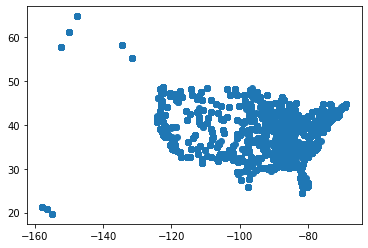

In [17]:
# Add co-ordinates so we can plot the path on a map
   
plt.scatter(x=dfFlights['Long'], y=dfFlights['Lat'])
plt.show()


In [18]:
# Pick a random starting airport

def LookForRandomPath(poolToChoose):

    # poolToChoose - How big a set of "close" destinations do I want to pick from

    r = random.randrange(0,len(dfFlights)-1)

    currentCity = (dfFlights.iloc[r])

    statesVisited = []
    citiesVisited = []
    totalDistance = 0

    while len(statesVisited)!=50:

        dfPossibleCities = dfFlights[~dfFlights['Destination_state'].isin(statesVisited)]
        dfPossibleCities = dfPossibleCities.query("Origin_city==@currentCity.Origin_city and Distance!=0")
        
        if (len(dfPossibleCities))==0:
            return -1,[],[]
            
        r2 = random.randrange(0,poolToChoose+1)
        if len(dfPossibleCities)-1<r2:
            r2 = 0
        
        nextCity = dfPossibleCities.sort_values("Distance").iloc[r2].Destination_city
        nextState = dfPossibleCities.sort_values("Distance").iloc[r2].Destination_state
        totalDistance += dfPossibleCities.sort_values("Distance").iloc[r2].Distance

        citiesVisited.append(nextCity)
        statesVisited.append(nextState)
    
    return totalDistance, statesVisited, citiesVisited

In [19]:
def GenerateMap(citiesVisited):

    lats = []
    lngs = []

    for city in citiesVisited:
        #print(city)
        lat = dfFlights.query("Origin_city==@city").iloc[0].Lat
        lng = dfFlights.query("Origin_city==@city").iloc[0].Long
        lats.append(lat)
        lngs.append(lng)
    fig = px.line_geo(lat=lats, lon=lngs)
    fig.show()

In [24]:

best = 100000000
tries = 0

for distance in range(10):

     for tries in range(10000):

          totalDistance, statesVisited, citiesVisited = LookForRandomPath(0)

          if totalDistance < best and totalDistance!=-1:
               #print(tries, totalDistance, statesVisited)
               best = totalDistance
               print(f"{best} miles on try {tries} and distance {distance+1}")
               #GenerateMap(citiesVisited)


41796 miles on try 2 and distance 0
40477 miles on try 10 and distance 0
40268 miles on try 25 and distance 0
38929 miles on try 27 and distance 0


KeyboardInterrupt: 

In [ ]:


for x in range(1,10):
    print(random.randrange(0,1))

0
0
0
0
0
0
0
0
0
